# Classifier model for personal spendings
Guilherme Machado

In [1]:
# plotting libs
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

from sklearn.pipeline import Pipeline

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV

# data
import pandas as pd
import numpy as np

# utils
from pathlib import Path
import pickle

# custom libs
from data_loader import load_treated_dataset
from training import split_train_test
from preprocess import get_preprocessing_transformer

c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Intro


This notebook presents a comprehensive workflow for building and evaluating machine learning models to classify personal spending transactions. 

The project follows best practices in intelligent software systems engineering, covering all key steps: data preparation, feature engineering, model training, hyperparameter tuning, evaluation, and model export for future use.
 
The workflow leverages popular machine learning libraries such as scikit-learn and pandas, and demonstrates the use of pipelines and cross-validation for robust model development.



## Problem Description
The goal of this notebook is to automate the classification of personal spending transactions into predefined categories. 

This is a common problem in personal finance management, where users want to track and analyze their expenses by category (e.g., groceries, utilities, entertainment). 

### Dataset
The dataset used in this notebook is a collection of labeled personal financial transactions, stored in the file `database_classified.parquet`. Each row represents a single transaction, and the dataset includes the following columns:

- **ID**: A unique identifier for each transaction.
- **Data**: The date of the transaction.
- **conta**: The account or source (e.g., bank or card) associated with the transaction.
- **Descrição**: A textual description of the transaction (e.g., merchant name, payment details).
- **categoria**: The category assigned to the transaction (e.g., "Alimentação cotidiana", "Transporte", "Saúde"). This is the target variable for classification.
- **Valor**: The monetary value of the transaction (negative for expenses, positive for income).
- **origem**: The original file or source from which the transaction was imported.

### Purpose and Use
The dataset is used to train and evaluate machine learning models that can automatically classify new transactions into the correct spending category based on their description, value, and other features. This helps users organize and analyze their personal finances more efficiently.

### Categories
The `categoria` column contains a variety of spending and income categories, such as:
- Alimentação cotidiana (everyday food)
- Transporte (transportation)
- Saúde (health)
- Compras (shopping)
- Salário (salary)
- Reembolsos (reimbursements)
- and many others.

### Preprocessing
Before being used for modeling, the dataset undergoes several preprocessing steps:
- Text normalization (e.g., lowercasing descriptions).
- Removal of unnecessary columns (e.g., account, ID, origin).
- Grouping rare categories into "Other" if they have too few samples.
- Feature engineering, such as extracting keywords from descriptions and processing dates.

This structured and preprocessed dataset enables the development of robust classification models for personal finance management.

## Models evaluated
The task is to train and compare various classification algorithms—including K-Nearest Neighbors, Decision Trees, Naive Bayes, and Support Vector Machines—to determine which model best predicts the spending category of new, unseen transactions. 

## Set Env variables

In [2]:
root_dir = Path('.')

In [3]:
test_size = 0.3
random_state = np.random.RandomState(0)
test_dataset_seed=1

## Load dataset

### Load data from file

In [4]:
complete_dataset = load_treated_dataset(root_dir)

In [5]:
complete_dataset.head()

,Data,Descrição,categoria,Valor
0,2022-10-10,parc=105ponto frio.c*3483 - parc.4/5,Presentes,-172.38
1,2022-11-20,ec*pantys - parc.3/3,Autocuidado - produtos,-91.83
2,2022-11-22,milena afradique - parc.2/3,Autocuidado - serviços,-566.67
3,2022-11-25,werner coiffeur bota - parc.2/3,Autocuidado - serviços,-483.33
4,2022-11-26,nespresso - parc.2/4,Alimentação cotidiana,-103.00


### Holdout: Split test and train

In [6]:
train, test = split_train_test(complete_dataset, test_size=test_size)
X_train = train[[i for i in train.columns if i != 'categoria']]

In [7]:
X_test = test[[i for i in test.columns if i != 'categoria']]

### Encode y classifications

In [8]:
y_train = train['categoria']
y_enconder = LabelEncoder().fit(y_train)
y_train_encoded = y_enconder.transform(y_train)

In [9]:
y_test = test['categoria']
y_test_encoded = y_enconder.transform(y_test)

## Data preprocessing pipeline
---
The `get_preprocessing_transformer` function builds a comprehensive data preprocessing pipeline using scikit-learn's `ColumnTransformer`. 

### Overview

The pipeline prepares the dataset for machine learning by transforming different types of features appropriately. It handles numeric, date, and text features, as well as engineered keyword features, ensuring the data is in the best format for model training.


### Steps in the Pipeline

1. **Numeric Features (`Valor`):**
   - **Transformation:** Standardization using `StandardScaler`.
   - **Purpose:** Ensures the numeric values (transaction amounts) have zero mean and unit variance, which helps many machine learning algorithms perform better.

2. **Date Features (`Data`):**
   - **Transformation:** 
     - Extracts day and month from the date.
     - Normalizes these values.
   - **Purpose:** Converts dates into useful numerical features (e.g., day, month) and scales them, making them suitable for model input.

3. **Text Features (`Descrição`):**
   - **Transformation:** 
     - **Text Embedding:** The description is tokenized and passed through a transformer model (DistilBERT), extracting a dense vector representation (CLS token) for each description.
     - **Keyword Hints:** Additional binary features are created for the presence of specific keywords (e.g., "pix", "uber", "ifd", etc.) in the description, and these are normalized.
     - **Combination:** Both the text embedding and keyword features are combined.
   - **Purpose:** Captures both the semantic meaning of the transaction description and the presence of important keywords, providing rich information for classification.

4. **Other Features:**
   - Any columns not explicitly transformed are passed through unchanged (`remainder='passthrough'`).

**In summary:**  
The `get_preprocessing_transformer` function creates a robust preprocessing pipeline that standardizes numeric values, extracts and normalizes date components, generates both deep and keyword-based text features, and ensures all relevant data is ready for machine learning models. This is crucial for achieving high classification accuracy in the personal spending categorization task.
- **Automated Feature Engineering:** The pipeline automates the extraction and transformation of features, reducing manual work and potential errors.
- **Consistency:** Ensures that the same transformations are applied during both training and inference.
- **Rich Feature Set:** By combining numeric, date, and advanced text features, the pipeline provides the model with a comprehensive view of each transaction.

In [10]:
data_transformer_without_token = get_preprocessing_transformer(pytorch=False)

data_transformer_without_token

,transformers,"[('standardscaler', ...), ('pipeline', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [11]:
data_transformer_with_token = get_preprocessing_transformer(pytorch=True)

data_transformer_with_token

,transformers,"[('standardscaler', ...), ('pipeline', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [12]:
custom_transformers = {'with description token': data_transformer_with_token, 'without description token': data_transformer_without_token}

## Model Cross-validation

### Cross-validation scoring
Scores used to evaluate models.

In [13]:
scoring = ['accuracy', 'balanced_accuracy', 'recall_weighted', 'precision_weighted',  'f1_weighted']

### Model candidates
Models used in cross-validation. Applies extra normalization necessary for some models.

In [16]:
model_candidates = {
    "Logistic Regression": LogisticRegression(random_state=random_state),
    "Ridge Classifier": RidgeClassifier(random_state=random_state),
    "Multinomial Naive Bayes": Pipeline(steps=[ Normalizer(),
                                                CategoricalNB()], verbose=False), # CategoricalNB does not support normalization, so we use Normalizer before it  
    "Gaussian Naive Bayes": Pipeline(steps=[ Normalizer(),
                                                GaussianNB()],  verbose=False), # CategoricalNB does not support normalization, so we use Normalizer before it  
    "Support Vector Machine Classifier": LinearSVC(verbose=0),
    "KNN": KNeighborsClassifier(),
    "Gradient boosting": GradientBoostingClassifier(
                            n_estimators=100,    # Number of boosting stages
                            learning_rate=0.1,   # Step size shrinkage
                            max_depth=3,         # Maximum depth of each tree
                            verbose=False, random_state=random_state
                        ),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, verbose=False, random_state=random_state),
    "AdaBoost Classifier": AdaBoostClassifier(n_estimators=100, random_state=random_state) 
}


### Create pipelines for each model

In [17]:
model_pipelines ={model_name + "-" + transformer_name: Pipeline(
                                steps=[("preprocessor", data_transformer), (model_name, model)],
                                verbose=False,
                                memory=str(root_dir.absolute())
                            ) for model_name, model in model_candidates.items() for transformer_name, data_transformer in custom_transformers.items()} 

### Run Cross-validation

In [18]:
cross_validation_avg_test_results = []

for model_name, clf in model_pipelines.items():
    print(f"Evaluating model: {model_name}")
    try:
        model_result = cross_validate(clf, X_train, y_train_encoded, scoring=scoring)
        model_avg = {i:v.mean() for i, v in  model_result.items() if 'test' in i}
        cross_validation_avg_test_results.append( {**model_avg, 'model': model_name})
    except Exception as e:
        print(f"Error in model: {model_name}: {e}")

Evaluating model: Logistic Regression-with description token


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 120/120 [00:12<00:00,  9.65 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


Map: 100%|██████████| 120/120 [00:01<00:00, 61.35 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


Map: 100%|██████████| 120/120 [00:01<00:00, 68.30 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


Map: 100%|██████████| 120/120 [00:04<00:00, 28.80 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


Map: 100%|██████████| 120/120 [00:03<00:00, 37.83 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Evaluating model: Logistic Regression-without description token
          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25
          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-c

          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27
          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


Evaluating model: Ridge Classifier-with description token
          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 120/120 [00:06<00:00, 18.55 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


Map: 100%|██████████| 120/120 [00:03<00:00, 38.45 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


Map: 100%|██████████| 120/120 [00:02<00:00, 50.08 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


Map: 100%|██████████| 120/120 [00:06<00:00, 17.45 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


Map: 100%|██████████| 120/120 [00:03<00:00, 38.63 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


Evaluating model: Ridge Classifier-without description token
          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02
          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-c

          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31
          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-c

          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20
Evaluating model: Multinomial Naive Bayes-with description token
          Data
126 2023-02-22
748 2023-11-23
613 2023-09-28
297 2023-05-24
575 2023-09-07


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
Map: 100%|██████████| 480/480 [00:15<00:00, 31.29 examples/s]


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 480/480 [00:19<00:00, 25.25 examples/s]


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 480/480 [00:19<00:00, 24.69 examples/s]


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 480/480 [00:15<00:00, 31.64 examples/s]


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 480/480 [00:18<00:00, 26.36 examples/s]


Error in model: Multinomial Naive Bayes-with description token: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\pipeline.py", line 661, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\guilh\Code

c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 120/120 [00:06<00:00, 18.44 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


Map: 100%|██████████| 120/120 [00:03<00:00, 35.14 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


Map: 100%|██████████| 120/120 [00:02<00:00, 43.72 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


Map: 100%|██████████| 120/120 [00:08<00:00, 14.59 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


Map: 100%|██████████| 120/120 [00:03<00:00, 37.55 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


Evaluating model: Support Vector Machine Classifier-without description token
          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02
          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-c

          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31
          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20
Evaluating model: KNN-with description token
          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 120/120 [00:06<00:00, 18.10 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


Map: 100%|██████████| 120/120 [00:03<00:00, 38.41 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


Map: 100%|██████████| 120/120 [00:02<00:00, 47.87 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


Map: 100%|██████████| 120/120 [00:06<00:00, 18.56 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


Map: 100%|██████████| 120/120 [00:03<00:00, 37.21 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Evaluating model: KNN-without description token
          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02
          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defin

          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31
          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-c

          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20
Evaluating model: Gradient boosting-with description token


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 120/120 [00:06<00:00, 19.40 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


Map: 100%|██████████| 120/120 [00:03<00:00, 38.55 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


Map: 100%|██████████| 120/120 [00:01<00:00, 67.16 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


Map: 100%|██████████| 120/120 [00:06<00:00, 19.00 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


Map: 100%|██████████| 120/120 [00:02<00:00, 40.85 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Evaluating model: Gradient boosting-without description token


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20
Evaluating model: Random Forest Classifier-with description token


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 120/120 [00:06<00:00, 19.34 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


Map: 100%|██████████| 120/120 [00:02<00:00, 42.55 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


Map: 100%|██████████| 120/120 [00:02<00:00, 52.89 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


Map: 100%|██████████| 120/120 [00:06<00:00, 19.50 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


Map: 100%|██████████| 120/120 [00:02<00:00, 42.38 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Evaluating model: Random Forest Classifier-without description token


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20
Evaluating model: AdaBoost Classifier-with description token


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 120/120 [00:06<00:00, 19.65 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


Map: 100%|██████████| 120/120 [00:02<00:00, 43.71 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


Map: 100%|██████████| 120/120 [00:02<00:00, 48.13 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27


Map: 100%|██████████| 120/120 [00:06<00:00, 19.82 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)


          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


Map: 100%|██████████| 120/120 [00:03<00:00, 39.86 examples/s]
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Evaluating model: AdaBoost Classifier-without description token


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
83  2023-01-29
72  2023-01-21
277 2023-05-07
57  2023-02-03
539 2023-08-25


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
607 2023-09-23
176 2023-03-18
396 2023-06-30
722 2023-11-11
193 2023-03-31


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


          Data
818 2023-12-14
196 2023-03-14
669 2023-10-23
382 2023-06-30
753 2023-11-27
          Data
549 2023-07-29
752 2023-11-24
484 2023-08-03
750 2023-11-24
369 2023-06-20


c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\utils\_response.py:203: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  target_type = type_of_target(classes)
c:\Users\guilh\Code\ControleFinanceiro\mvp-classifier\.venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### Cross-validation Analysis

In [19]:
model_crossvalidation_results = pd.DataFrame(cross_validation_avg_test_results)

In [20]:
model_crossvalidation_results['avg_score'] = model_crossvalidation_results[[i for i in model_crossvalidation_results.columns if 'test' in i]].mean(axis=1)
model_crossvalidation_results = model_crossvalidation_results.sort_values(by='avg_score', ascending=False)
model_crossvalidation_results.set_index('model', inplace=True)
model_crossvalidation_results

,test_accuracy,test_balanced_accuracy,test_recall_weighted,test_precision_weighted,test_f1_weighted,avg_score
model,,,,,,
Ridge Classifier-with description token,0.708333,0.530083,0.708333,0.695096,0.687624,0.665894
Support Vector Machine Classifier-with description token,0.700000,0.520466,0.700000,0.687177,0.681543,0.657837
Logistic Regression-with description token,0.690000,0.493962,0.690000,0.668213,0.664068,0.641249
Random Forest Classifier-with description token,0.676667,0.502294,0.676667,0.668083,0.646961,0.634134
Gradient boosting-with description token,0.638333,0.489246,0.638333,0.642173,0.623132,0.606243
KNN-with description token,0.595000,0.384176,0.595000,0.578802,0.560988,0.542793
Gradient boosting-without description token,0.548333,0.420973,0.548333,0.552223,0.537041,0.521381
Random Forest Classifier-without description token,0.541667,0.423891,0.541667,0.541804,0.534010,0.516608
KNN-without description token,0.475000,0.334947,0.475000,0.458126,0.458001,0.440215


Text(0.5, 1.0, 'Model Cross-Validation Results')

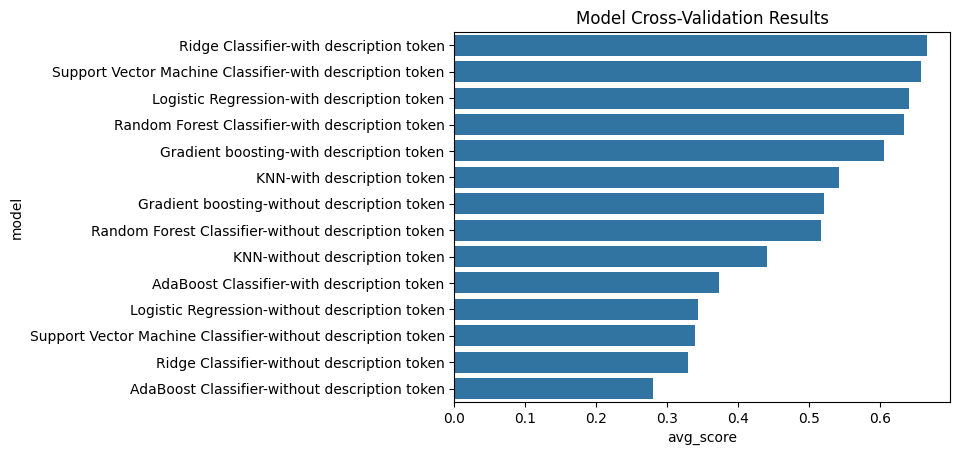

In [21]:
sns.barplot(data=model_crossvalidation_results, x='avg_score', y=model_crossvalidation_results.index, orient='h')
plt.title('Model Cross-Validation Results')

## Select the best models for hyperparameter tunning

In [25]:
best_models = model_crossvalidation_results.index[:3].to_list()
print(f"Best models were: {best_models}")

Best models were: ['Ridge Classifier', 'Logistic Regression', 'Random Forest Classifier']


## Hyper-parameters selection

### Setting parameters for gridsearch

In [ ]:
param_grid = {
                "Ridge Classifier" :{'alpha': np.linspace(0.1, 1, num = 3), 
                                    'class_weight': ['balanced', None]},
                "Logistic Regression" :{
                                        'solver' : ['lbfgs', 'liblinear', 'sag'],
                                        'C': [10, 1.0, 0.1]},
                "Random Forest Classifier" :{
                                            # 'criterion': ['gini', 'entropy'],
                                            # 'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                                            # 'min_samples_leaf': [1, 2, 4],
                                            'min_samples_split': [2, 5, 10],
                                            'max_features': [None, 'sqrt', 0.3],
                                            # 'n_estimators':[int(x) for x in np.linspace(start = 40, stop = 150, num = 20)]
                                            },
            }

### Tunning

In [ ]:
hyper_param_tunning_results = {}
#preprocess data for the hyper parameter tuning
X_train_processed =  data_transformer.fit(X_train).transform(X_train)
for model_name, params in param_grid.items():
    print(f"Running grid search for model: {model_name}")
    model =  model_candidates[model_name]
    grid = param_grid[model_name]
    
    # Perform grid search
    grid_search = GridSearchCV(estimator=model, cv=2, param_grid=grid, scoring='f1_weighted', verbose=0, n_jobs=-1)
    grid_result = grid_search.fit(X_train_processed, y_train)
    hyper_param_tunning_results[model_name] = grid_result

### Hyperparameter tunning analysis

In [ ]:
hyperparameter_tunning_scores = {estimator:grid_search.best_score_ for estimator,grid_search in hyper_param_tunning_results.items()}

best_estimator = sorted(hyperparameter_tunning_scores.items(), key=lambda item: item[1], reverse=True)[0]

In [38]:
print(f'best estimator is {best_estimator[0]} with score {best_estimator[1]} and parameters {hyper_param_tunning_results[best_estimator[0]].best_params_}')

best estimator is Ridge Classifier with score 0.6566580372496947 and parameters {'alpha': np.float64(0.55), 'class_weight': None}


<Axes: >

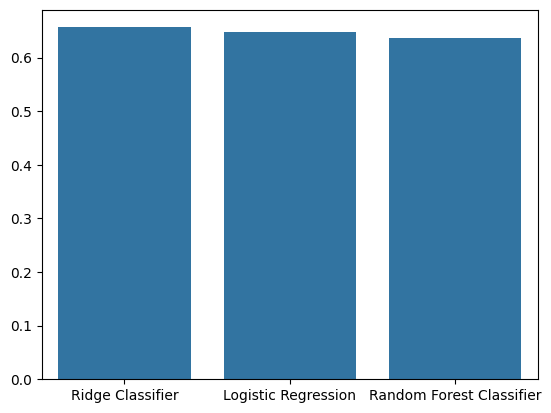

In [29]:
sns.barplot({estimator:grid_search.best_score_ for estimator,grid_search in hyper_param_tunning_results.items()})

### Re-run cross-validation with best parameters

In [ ]:
hyper_parameter_scores = []
model_names = []
# Parâmetros e partições da validação cruzada
scoring = 'f1_weighted'
splits = 3
kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=random_state) # validação cruzada com estratificação

for model_name, clf in hyper_param_tunning_results.items():
    print(f"Evaluating model: {model_name}")
    model = clf.best_estimator_
    try:
        model_result = cross_val_score(clf, X_train_processed, y_train_encoded, scoring=scoring, verbose=0 )
        hyper_parameter_scores.append(model_result)
        model_names.append(model_name)
    except Exception as e:
        print(f"Error in model: {model_name}: {e}")

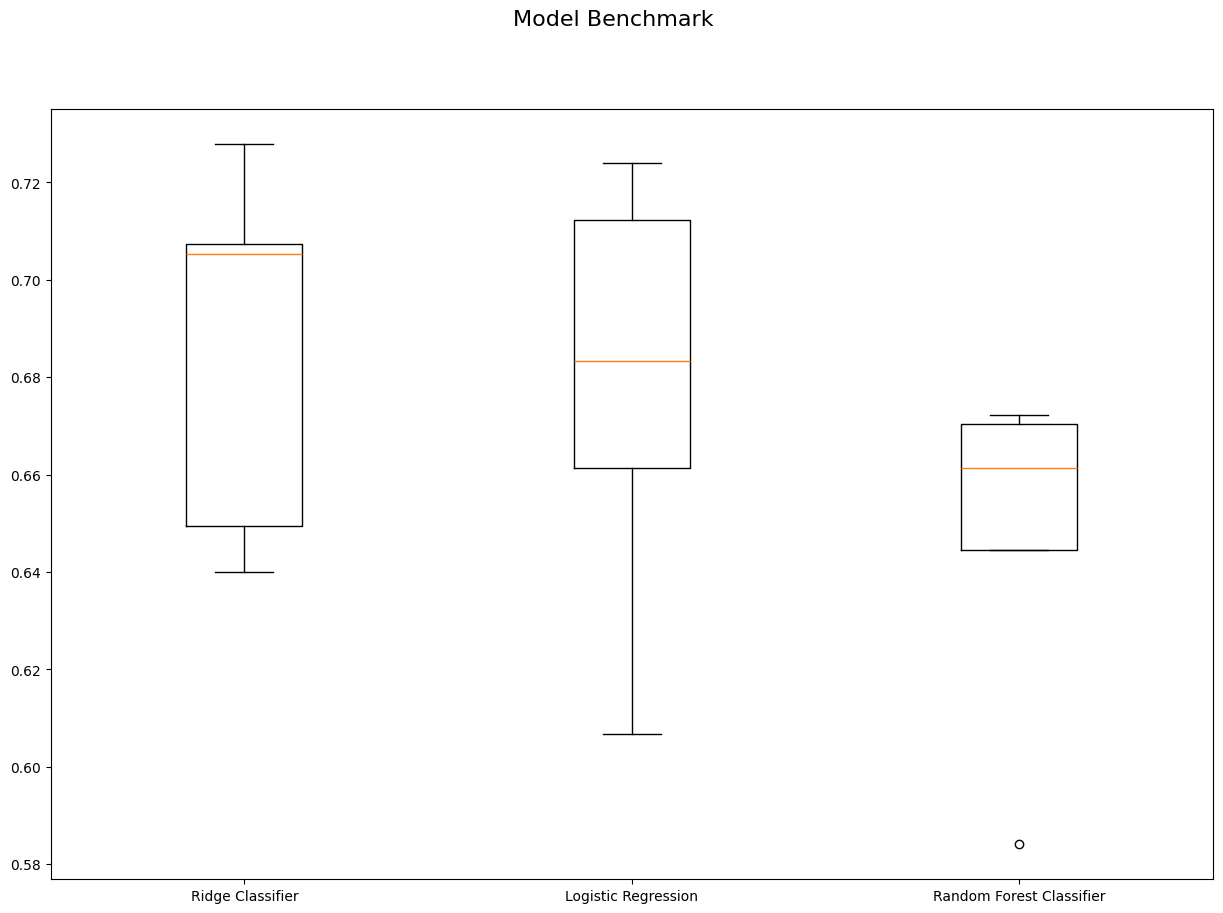

In [52]:
# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Model Benchmark', fontsize=16)
ax = fig.add_subplot(111)
plt.boxplot(hyper_parameter_scores)
ax.set_xticklabels(model_names)
plt.show()

## Test Model

In [ ]:
X_test_processed =  data_transformer.fit(X_train).transform(X_test)

          Data
38  2023-01-18
749 2023-11-24
91  2023-02-02
557 2023-08-28
152 2023-03-02


Map: 100%|██████████| 600/600 [00:08<00:00, 68.39 examples/s]


          Data
134 2022-12-11
206 2023-04-01
714 2023-11-07
720 2023-11-10
69  2023-01-19


Map: 100%|██████████| 258/258 [00:05<00:00, 45.60 examples/s]


In [ ]:
model_names = []

metrics = [('balanced_accuracy_score', balanced_accuracy_score), ('confusion_matrix', confusion_matrix)]
test_scores = { metric_name: [] for metric_name, _ in metrics }

for model_name, clf in hyper_param_tunning_results.items():
    print(f"Evaluating model: {model_name}")
    model = clf.best_estimator_
    model_names.append(model_name)
    try:
        predictions = model.predict(X_test_processed, random_state=random_state)
        predictions_encoded = y_enconder.transform(predictions)

        for metric_name, metric in metrics:
            if metric == roc_auc_score:
                model_result = metric(y_test_encoded, predictions_encoded, average='weighted')
            else:
                model_result = metric(y_test_encoded, predictions_encoded)
            test_scores[metric_name].append(model_result) 
    except Exception as e:
        print(f"Error in model: {model_name}: {e}")

Evaluating model: Ridge Classifier
Evaluating model: Logistic Regression
Evaluating model: Random Forest Classifier


C:\Users\guilh\AppData\Local\Temp\ipykernel_29092\1286417807.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names)


[Text(0, 0, 'Ridge Classifier'),
 Text(1, 0, 'Logistic Regression'),
 Text(2, 0, 'Random Forest Classifier')]

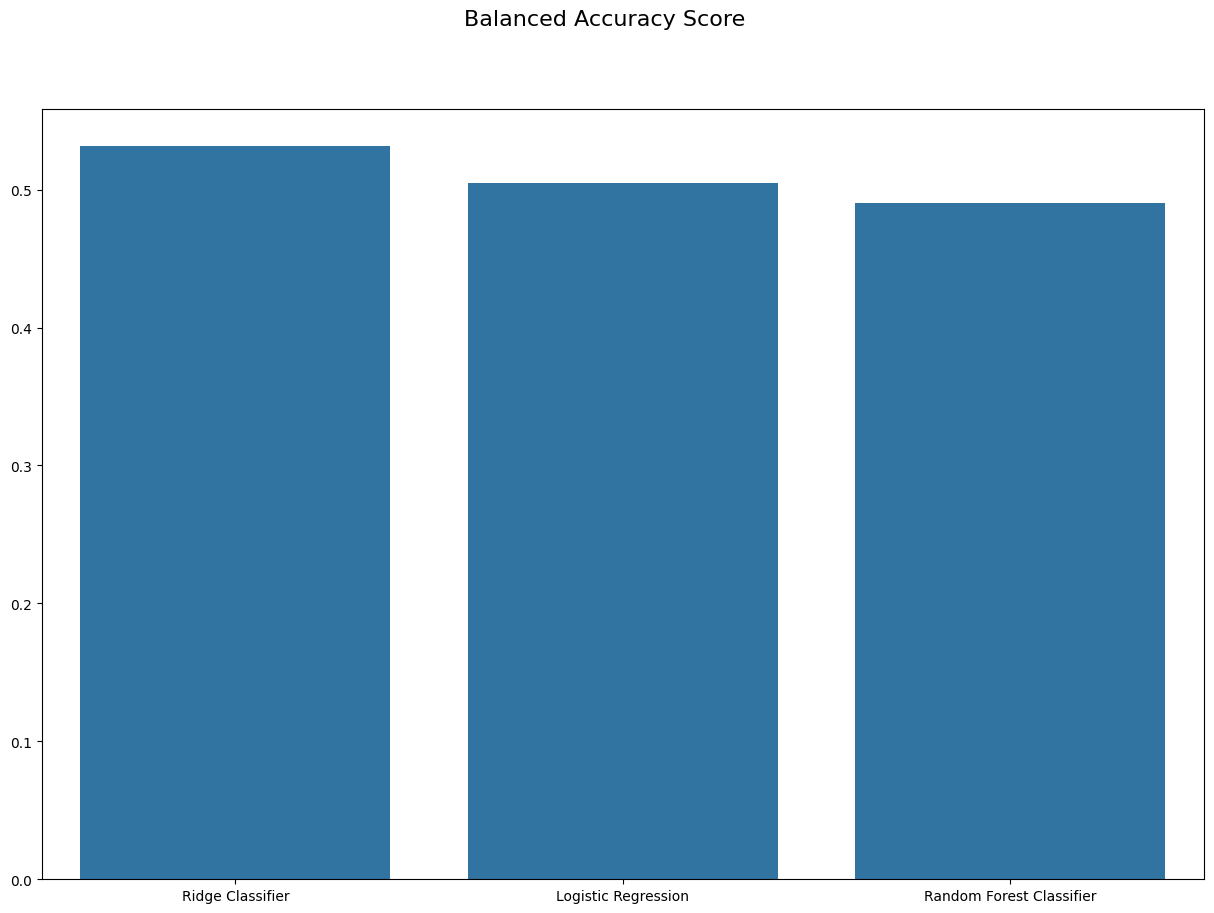

In [97]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Balanced Accuracy Score', fontsize=16)
ax = fig.add_subplot(111)
sns.barplot(test_scores['balanced_accuracy_score'])
ax.set_xticklabels(model_names)

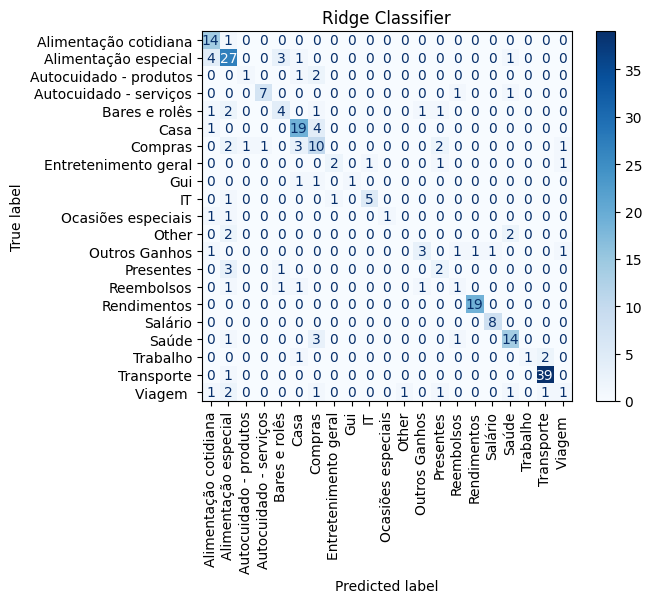

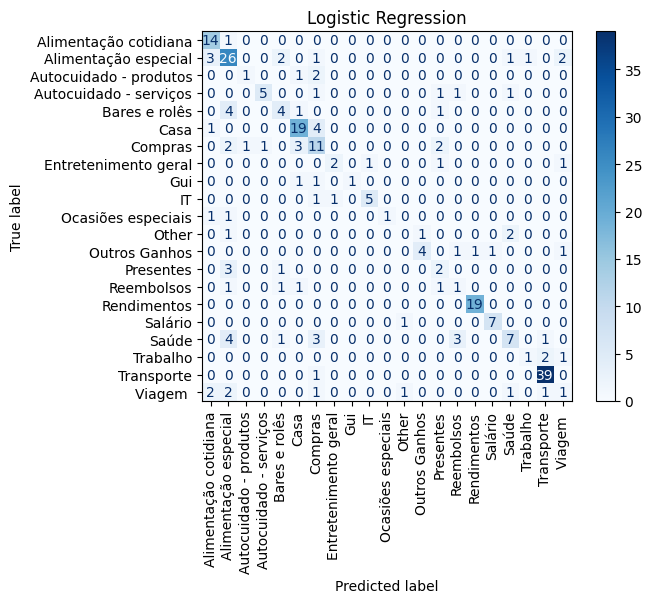

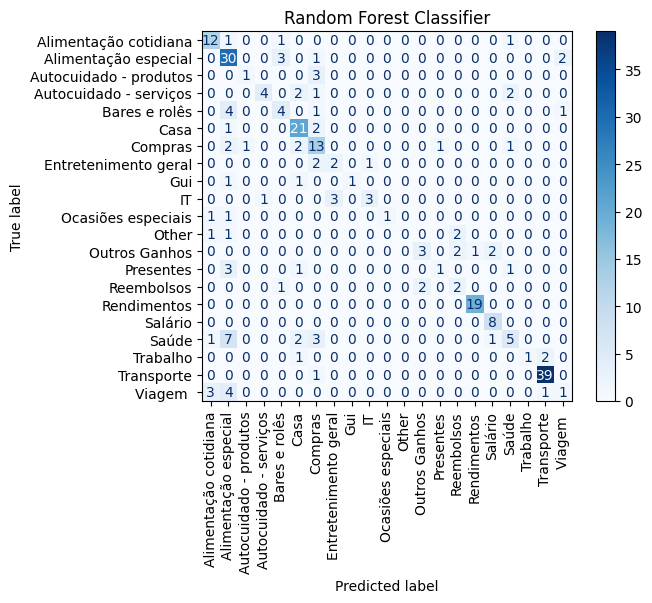

In [ ]:
nrows=len(model_names)
ncols=1 
for i, model_name in enumerate(model_names):
    data = test_scores['confusion_matrix'][i]
    model = hyper_param_tunning_results[model_name].best_estimator_
    try:
        ax = fig.add_subplot(nrows,ncols,i+1)
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test_processed,
            y_test,
            display_labels=y_enconder.classes_,
            cmap=plt.cm.Blues,
        )
        
        disp.ax_.set_title(model_name)
        disp.ax_.tick_params(axis='x', labelrotation=90)
    except:
        print('Rrror ploting confusion matrix for model: ', model_name)

## Save model

In [ ]:
def save_data_pkl(file_path, obj):
    with open(file_path, "wb") as f:
        print(f'Saving the "{file_path}"')
        pickle.dump(obj, f)

In [ ]:
print(f'Saving the "{best_estimator[0]}" model to classification_model.pkl')
save_data_pkl("classification_model.pkl", hyper_param_tunning_results[best_estimator[0]].best_estimator_)

Saving the "Ridge Classifier" model to classification_model.pkl


### Save data for testing the model

In [171]:
np.random.seed(test_dataset_seed)
model = hyper_param_tunning_results['Ridge Classifier'].best_estimator_
predictions = model.predict(X_test_processed)
predictions_encoded = y_enconder.transform(predictions)

In [ ]:
save_data_pkl("X_test_preprocessed.pkl", X_test_processed)   

Saving the "X_test_preprocessed" data to pkl
Saving the "X_test_preprocessed.pkl"


In [172]:
X_test_processed.sum()

np.float64(-1245.1475847264246)

In [158]:
save_data_pkl(f"y_predictions_seed_{test_dataset_seed}.pkl", predictions)   

Saving the "y_predictions_seed_1.pkl"


In [161]:
save_data_pkl(f"model_result_seed_{test_dataset_seed}.pkl", model_result)   

Saving the "model_result_seed_1.pkl"


In [ ]:
save_data_pkl(f"y_enconder.pkl", y_enconder)   

Saving the "y_enconder_seed_1.pkl"


In [173]:
balanced_accuracy_score(y_test_encoded, predictions_encoded)

0.53166746230656

In [ ]:
metric_name, metric = metrics[0]
model_result = balanced_accuracy_score(y_test_encoded, predictions_encoded)
save_data_pkl(f"{metric_name}_seed_{test_dataset_seed}.pkl", test_scores[metric_name][0])   

Saving the "balanced_accuracy_score_seed_1.pkl"


In [175]:
save_data_pkl(f"X_test_raw.pkl", X_test)   

Saving the "X_test_raw.pkl"


In [176]:
preprocessor.transform(X_test)

          Data
134 2022-12-11
206 2023-04-01
714 2023-11-07
720 2023-11-10
69  2023-01-19


Map: 100%|██████████| 258/258 [00:05<00:00, 43.89 examples/s]


array([[-0.17824334,  0.67572463,  0.73715414, ...,  0.        ,
         0.        ,  0.        ],
       [-0.3444607 ,  0.24253563,  0.9701425 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.22377174,  0.53687549,  0.84366149, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.10325312,  0.8       ,  0.6       , ...,  0.        ,
         0.        ,  0.        ],
       [-0.12472425,  0.70710678,  0.70710678, ...,  0.        ,
         0.        ,  0.        ],
       [-0.08314475,  0.9701425 ,  0.24253563, ...,  0.        ,
         0.        ,  0.        ]], shape=(258, 779))